# 逻辑回归Sklearn实现

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

## 1. 逻辑回归中的L1正则化和稀疏性
通过对比使用不同的正则化参数得到的权重矩阵，来确定其稀疏性，也就是权重矩阵中值为0的权重数量。

In [2]:
# 加载sklearn中的手写数字数据集
digits = datasets.load_digits()
# 获取特征和类别标签
X, y = digits.data, digits.target
# 归一化参数
X = StandardScaler().fit_transform(X)
# 为了做二分类而不是多分类，将数字以4为分界点分为正反两个部分
y = (y > 4).astype(np.int)
X, y

(array([[ 0.        , -0.33501649, -0.04308102, ..., -1.14664746,
         -0.5056698 , -0.19600752],
        [ 0.        , -0.33501649, -1.09493684, ...,  0.54856067,
         -0.5056698 , -0.19600752],
        [ 0.        , -0.33501649, -1.09493684, ...,  1.56568555,
          1.6951369 , -0.19600752],
        ...,
        [ 0.        , -0.33501649, -0.88456568, ..., -0.12952258,
         -0.5056698 , -0.19600752],
        [ 0.        , -0.33501649, -0.67419451, ...,  0.8876023 ,
         -0.5056698 , -0.19600752],
        [ 0.        , -0.33501649,  1.00877481, ...,  0.8876023 ,
         -0.26113572, -0.19600752]]), array([0, 0, 0, ..., 1, 1, 1]))

C = 100.00
Sparsity with L1 penalty: 6.25%
score with L1 penalty: 0.9098
Sparsity with L2 penalty: 4.69%
score with L2 penalty: 0.9098


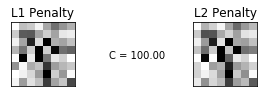

C = 1.00
Sparsity with L1 penalty: 9.38%
score with L1 penalty: 0.9098
Sparsity with L2 penalty: 4.69%
score with L2 penalty: 0.9093


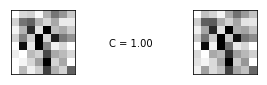

C = 0.01
Sparsity with L1 penalty: 85.94%
score with L1 penalty: 0.8631
Sparsity with L2 penalty: 4.69%
score with L2 penalty: 0.8915


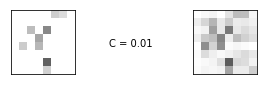

In [3]:
for i, C in enumerate((100, 1, 0.01)):
    # 设置正则化参数C（也就是1 / lambda)，tol为停止条件
    # C过大欠拟合，C过小过拟合
    clf_l1_LR = LogisticRegression(C = C, penalty='l1', tol=0.01)
    clf_l2_LR = LogisticRegression(C = C, penalty='l2', tol=0.01)
    clf_l1_LR.fit(X, y)
    clf_l2_LR.fit(X, y)
    
    # 得到l1正则和l2正则的系数向量
    coef_l1_LR = clf_l1_LR.coef_.ravel()
    coef_l2_LR = clf_l2_LR.coef_.ravel()
    
    # 解的稀疏度
    sparsity_l1_LR = np.mean(coef_l1_LR == 0) * 100
    sparsity_l2_LR = np.mean(coef_l2_LR == 0) * 100
    print("C = %.2f" % C)
    print("Sparsity with L1 penalty: %.2f%%" % sparsity_l1_LR)
    print("score with L1 penalty: %.4f" % clf_l1_LR.score(X, y))
    print("Sparsity with L2 penalty: %.2f%%" % sparsity_l2_LR)
    print("score with L2 penalty: %.4f" % clf_l2_LR.score(X, y))
    
    # 绘制不同正则化参数下的图像
    l1_plot = plt.subplot(3, 2, 2*i + 1)
    l2_plot = plt.subplot(3, 2, 2*(i + 1))
    if i == 0:
        l1_plot.set_title("L1 Penalty")
        l2_plot.set_title("L2 Penalty")
    # imshow绘制热图，这里显示非零的色块占比
    l1_plot.imshow(np.abs(coef_l1_LR.reshape(8, 8)), interpolation='nearest',
                   cmap='binary', vmax=1, vmin=0)
    l2_plot.imshow(np.abs(coef_l2_LR.reshape(8, 8)), interpolation='nearest',
                   cmap='binary', vmax=1, vmin=0)
    # text方法两个参数调整后面输出文字的位置，-11调整左右位置，4调整上下位置
    plt.text(-11, 4, "C = %.2f" % C)
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    l2_plot.set_xticks(())
    l2_plot.set_yticks(())
    plt.show()

从上面输出结果可以看出，当C较小时，权重矩阵比较稀疏，也就是为0的项较多，模型欠拟合。相反，模型过拟合。

## 2. L1正则逻辑回归的路径

In [4]:
from datetime import datetime

from sklearn import linear_model
from sklearn.svm import l1_min_c

In [5]:
# 使用iris数据集
iris = datasets.load_iris()
X, y = iris.data, iris.target
X = X[y != 2]
y = y[y != 2]
X -= np.mean(X, 0)
X[:3], y[:3]

(array([[-0.371,  0.406, -1.462, -0.585],
        [-0.571, -0.094, -1.462, -0.585],
        [-0.771,  0.106, -1.562, -0.585]]), array([0, 0, 0]))

In [6]:
# l1_min_c返回最小的C使得模型不为空
# 这里创建了50个递进的C值。logspace默认的长度为50
cs = l1_min_c(X, y, loss='log') * np.logspace(0, 3)

Computing regularization path ...
This took  0:00:00.021993


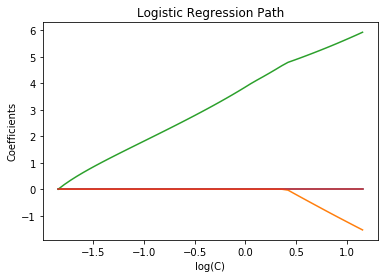

In [7]:
print("Computing regularization path ...")
start = datetime.now()
clf = linear_model.LogisticRegression(C=1.0, penalty='l1', tol=1e-6)
coefs_ = []
for c in cs:
    clf.set_params(C=c)
    clf.fit(X, y)
    coefs_.append(clf.coef_.ravel().copy())
# 计算运行时间
print("This took ", datetime.now() - start)
coefs_ = np.array(coefs_)
plt.plot(np.log10(cs), coefs_)
ymin, ymax = plt.ylim()
plt.xlabel('log(C)')
plt.ylabel('Coefficients')
plt.title('Logistic Regression Path')
plt.axis('tight')
plt.show()

## 3. 多项式和一对多的逻辑回归

In [8]:
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression

In [10]:
centers = [[-5, 0], [0, 1.5], [5, -1]]
# make_blobs用于聚类算法测试生成样本，默认特征值数为2。
# n_samples为样本数，centers为聚类中心，random_state为随机种子
X, y = make_blobs(n_samples=1000, centers=centers, random_state=40)
transformation = [[0.4, 0.2], [-0.4, 1.2]]
X = np.dot(X, transformation)
X

array([[-2.38519938,  0.02641654],
       [-1.74830343, -1.4226907 ],
       [-2.45431681, -1.46071435],
       ...,
       [-1.88691344, -1.67526794],
       [-0.96714666,  4.62965124],
       [ 1.21127093,  1.53964501]])

Training score : 0.995 (multinomial)
Training score : 0.976 (ovr)


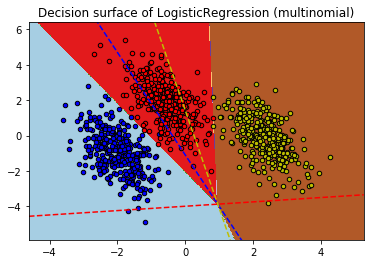

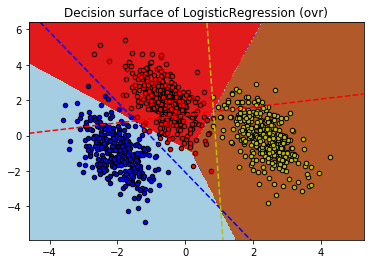

In [11]:
# 多项式多分类和一对多多分类
for multi_class in ('multinomial', 'ovr'):
    clf = LogisticRegression(solver='sag', max_iter=100, random_state=42, multi_class=multi_class).fit(X, y)
    print("Training score : %.3f (%s)" % (clf.score(X, y), multi_class))
    
    # 绘制图像
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # 绘制决策边界，为每个类别上色
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
    plt.title("Decision surface of LogisticRegression (%s)" % multi_class)
    plt.axis('tight')
    
    # 绘制数据点
    colors = 'bry'
    for i, color in zip(clf.classes_, colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, cmap=plt.cm.Paired,
                    edgecolor='black', s=20)
    
    # 绘制三个一对多分类器的决策边界
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    coef = clf.coef_
    intercept = clf.intercept_
    
    def plot_hyperplane(c, color):
        def line(x0):
            return (-(x0 * coef[c, 0]) - intercept[c]) / coef[c, 1]
        plt.plot([xmin, xmax], [line(xmin), line(xmax)], ls='--', color=color)
    
    for i, color in zip(clf.classes_, colors):
        plot_hyperplane(i, color)

plt.show()

## 4. 逻辑回归3类分类器

In [12]:
iris = datasets.load_iris()
X = iris.data[:, :2]
y = iris.target
X[:10], y[:10]

(array([[5.1, 3.5],
        [4.9, 3. ],
        [4.7, 3.2],
        [4.6, 3.1],
        [5. , 3.6],
        [5.4, 3.9],
        [4.6, 3.4],
        [5. , 3.4],
        [4.4, 2.9],
        [4.9, 3.1]]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

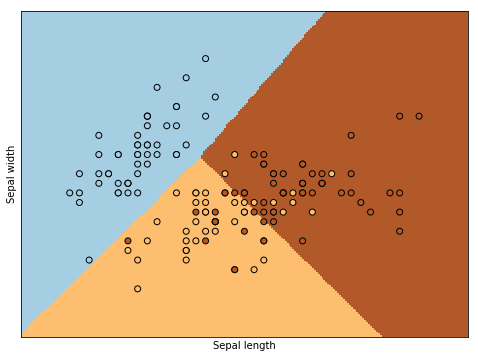

In [14]:
h = .02
logreg = linear_model.LogisticRegression(C=1e5)
logreg.fit(X, y)

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])
# 绘制决策边界
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(8, 6))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# 绘制训练点
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

plt.show()